In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Define values for rate constants (k)
k1 = 100000000       # kon for E + S to ES
k2 = 100                 # koff for ES to E + S
k3 = 100000000       # kon for E + I to non-covalent EI
k4 = 10                       # koff for EI to E + I
k5 = 0.001                # kon for EI to covalent EI*
k6 = 0                      # koff for covalent EI* to non-covalent EI
kcat = 1                 # kon ES to E+P

# Define concentrations at start of measurement t=0 (before addition of inhibitor or substrate)
E0 = 1*10**-12 # Enzyme concentration before dilution!
ES0 = 0
P0 = 0
EI0 = 0 #Non-covalent enzyme-inhibitor complex EI
EIi0 = 0  #Covalent enzyme-inhibitor complex (EI*) 
V0 = 1 #Volume before addition of the substrate

#Define assay constants
Is = [1*10**-6, 0.5*10**-6, 0.25*10**-6, 0.15*10**-6, 0.075*10**-6, 0.04*10**-6, 0.02*10**-6, 10*10**-9, 5*10**-9, 2.5*10**-9, 1.0*10**-9, 0*10**-9] # List of inhibitor concentrations. Concentration before dilution! Is assumed to be constant, which is only true if inhibitor concentration is >10*E0.
S0 = 1000*10**-9 # Substrate concentration. Is assumed to be constant, which is only true if substrate conversion is less than 10%
VS = 99 # Volume of added substrate, assumed is that S0 = S/VS (so based on volume of substrate, not final volume)
Vtot = V0+VS #Total volume after addition of substrate
dt = 0.001 # Seconds per simulation step (dt). Minimum value for dt defined by k1*S0*dt<1 and k3*I0*dt <1

tframe = 60 # Save a frame every 'tframe' seconds
tincub = 14400 # Preincubate with inhibitor for 'tincub' seconds
tsub = 1800 # Run with substrate for 'tsub' seconds

In [ ]:
all_conc = []
all_t0 = []
all_t1 = []
for I in Is: # Loop over all I's
    all_conc.append(np.array([E0, ES0, P0, EI0, EIi0], dtype=np.double)) #matrix van concentraties
    # Voor toevoeging van S

    S=0 # Geen S in je systeem
        
                            # [         E,       ES, P,     EI, EI*]
    all_t0.append(np.array([[-k3*I-k1*S,  k2+kcat, 0,     k4,   0],  #E
                            [      k1*S, -k2-kcat, 0,      0,   0],  #ES
                            [         0,     kcat, 0,      0,   0],  #P
                            [      k3*I,        0, 0, -k4-k5,  k6],  #EI
                            [         0,        0, 0,     k5, -k6]]).T) #EI*

    # Change in E   = [E]*(-k3*I-k1*S) + [ES]*(k2+kcat)  + [P]*(0) + [EI]*(k4)     + [EI*]*(0)
    # Change in ES  = [E]*(k1*S)       + [ES]*(-k2-kcat) + [P]*(0) + [EI]*(0)      + [EI*]*(0)
    # Change in P   = [E]*(0)          + [ES]*(kcat)     + [P]*(0) + [EI]*(0)      + [EI*]*(0)
    # Change in EI  = [E]*(k3*I)       + [ES]*(0)        + [P]*(0) + [EI]*(-k4-k5) + [EI*]*(k6)
    # Change in EI* = [E]*(0)          + [ES]*(0)        + [P]*(0) + [EI]*(k5)     + [EI*]*(-k6)


    #Na toevoeging van S
    S= S0*(VS/Vtot) #Substrate concentration after addition
    I = I*(V0/Vtot) #New inhibitor concentration after S addition
    all_t1.append(np.array([[-k3*I-k1*S, k2+kcat, 0, k4, 0],
                            [k1*S, -k2-kcat, 0, 0, 0],
                            [0, kcat, 0, 0, 0],
                            [k3*I, 0, 0, -k4-k5, k6],
                            [0, 0, 0, k5, -k6]]).T)
    # Maak een lijst van kopien van de concentraties
concentraties = np.stack(all_conc)  
t0 = np.stack(all_t0)
t1 = np.stack(all_t1)                
plot = [concentraties.copy()]

tijdconc = concentraties.copy()
t = 0
# Voor toevoging van S (tincub/dt stappen = 30min)
for i in range(int(tincub/dt)):
    t+= 1
    tijdconc += np.dot(tijdconc, t0*dt).diagonal().T
    #tijdconc += [diff[i].T[i] for i in range(len(Is))] # Doe 1 dt tijdstap
    if (tijdconc < 0).any():
        raise ValueError("got a negative concentration, try decreasing dt")

    if t % int(tframe/dt)==0:
        plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

# Na toevoeging van S (tsub/dt stappen)
tijdconc *= (V0/Vtot) #Dilute everything
for i in range(int(tsub/dt)):
    t += 1
    tijdconc += np.dot(tijdconc, t1*dt).diagonal().T   
    if (tijdconc < 0).any():
        raise ValueError("got a negative concentration, try decreasing dt")

    if t % int(tframe/dt)==0:
        plot.append(tijdconc.copy()) # Voeg de nieuwe concentraties toe aan de lijst

In [ ]:
all_plots = np.array(plot).swapaxes(0,1) #swap ax 0 and ax 1

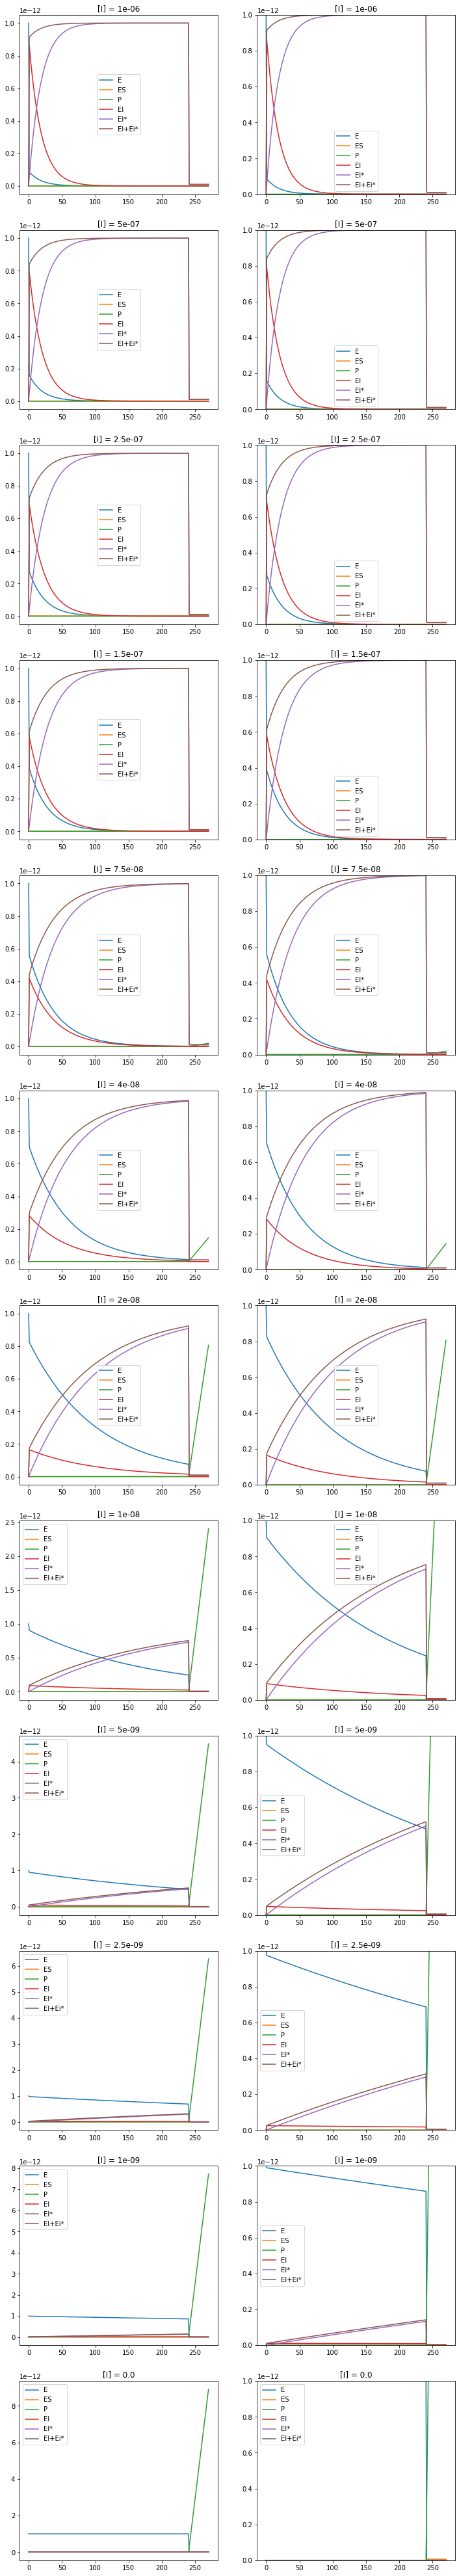

In [ ]:
# This will make all the plots and dataframes
dataframes = []
fig, axes = plt.subplots(len(all_plots), 2, figsize=(12,len(all_plots)*6))
for n, plot in enumerate(all_plots):
  # Splits de lijst van figuren in E, ES, P, EI en EI*
  Eplot = [] 
  ESplot = []
  Pplot = []
  EIplot = []
  EIiplot = []
  EItot = []
  for frame in plot:
    Eplot.append(frame[0])
    ESplot.append(frame[1])
    Pplot.append(frame[2])
    EIplot.append(frame[3])
    EIiplot.append(frame[4])
    EItot.append(frame[3]+frame[4]) 
    
   # Plot de figuren
  labels = ('E', 'ES', "P", "EI", "EI*", "EI+Ei*")
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
    axes[n,0].plot(y, label=labels[i])
  axes[n,0].legend()
  for i,y in enumerate((Eplot, ESplot, Pplot, EIplot, EIiplot, EItot)):
      axes[n,1].plot(y, label=labels[i])
  axes[n,1].legend()
  axes[n,1].set_ylim(0,E0) #zoom in tot E0
  axes[n,0].set_title("[I] = {}".format(str(Is[n])))
  axes[n,1].set_title("[I] = {}".format(str(Is[n])))
  
  df = pd.DataFrame(data={'E':Eplot,  "EI":EIplot, "EIi":EIiplot, "ES":ESplot, "P":Pplot})
  dataframes.append(df)
df = pd.concat(dataframes, keys=[I for I in Is], axis=1) # Combine all the dataframes

In [ ]:
df

0.000001                              ... 0.000000                            
                E            EI           EIi  ...      EIi            ES             P
0    1.000000e-12  0.000000e+00  0.000000e+00  ...      0.0  0.000000e+00  0.000000e+00
1    8.608465e-14  8.608387e-13  5.307669e-14  ...      0.0  0.000000e+00  0.000000e+00
2    8.151489e-14  8.151415e-13  1.033437e-13  ...      0.0  0.000000e+00  0.000000e+00
3    7.718771e-14  7.718701e-13  1.509422e-13  ...      0.0  0.000000e+00  0.000000e+00
4    7.309024e-14  7.308957e-13  1.960140e-13  ...      0.0  0.000000e+00  0.000000e+00
..            ...           ...           ...  ...      ...           ...           ...
266  9.204318e-21  9.203442e-22  9.999981e-15  ...      0.0  4.950000e-15  7.721975e-12
267  9.177810e-21  9.176937e-22  9.999981e-15  ...      0.0  4.950000e-15  8.018975e-12
268  9.151379e-21  9.150508e-22  9.999981e-15  ...      0.0  4.950000e-15  8.315975e-12
269  9.125024e-21  9.124155e-22  9.999981e-15  ...      0.0  4.950000e-15  8.612975e-12
270  9.098744e-21  9.097878e-22  9.999981e-15  ...      0.0  4.950000e-15  8.909975e-12

[271 rows x 60 columns]

In [ ]:
# Printing the values at timepoint
df.iloc[10]

1.000000e-06  E      5.268982e-14
              EI     5.268934e-13
              EIi    4.204168e-13
              ES     0.000000e+00
              P      0.000000e+00
5.000000e-07  E      1.010914e-13
              EI     5.054484e-13
              EIi    3.934602e-13
              ES     0.000000e+00
              P      0.000000e+00
2.500000e-07  E      1.861337e-13
              EI     4.653209e-13
              EIi    3.485455e-13
              ES     0.000000e+00
              P      0.000000e+00
1.500000e-07  E      2.790855e-13
              EI     4.186115e-13
              EIi    3.023030e-13
              ES     0.000000e+00
              P      0.000000e+00
7.500000e-08  E      4.418869e-13
              EI     3.313962e-13
              EIi    2.267169e-13
              ES     0.000000e+00
              P      0.000000e+00
4.000000e-08  E      6.017873e-13
              EI     2.406977e-13
              EIi    1.575150e-13
              ES     0.000000e+00
              

In [ ]:
print(df.to_csv())

,1e-06,1e-06,1e-06,1e-06,1e-06,5e-07,5e-07,5e-07,5e-07,5e-07,2.5e-07,2.5e-07,2.5e-07,2.5e-07,2.5e-07,1.5e-07,1.5e-07,1.5e-07,1.5e-07,1.5e-07,7.5e-08,7.5e-08,7.5e-08,7.5e-08,7.5e-08,4e-08,4e-08,4e-08,4e-08,4e-08,2e-08,2e-08,2e-08,2e-08,2e-08,1e-08,1e-08,1e-08,1e-08,1e-08,5e-09,5e-09,5e-09,5e-09,5e-09,2.5e-09,2.5e-09,2.5e-09,2.5e-09,2.5e-09,1e-09,1e-09,1e-09,1e-09,1e-09,0.0,0.0,0.0,0.0,0.0
,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P,E,EI,EIi,ES,P
0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0,1e-12,0.0,0.0,0.0,0.0
1,8.608464883152296e-14,8.60838662444531e-13,5.307668872396169e-14,0.0,0.0,1.5854266004721788e-13,7.927000883844522e-13,4.875725156835499e-14,0.0,0.0,2.7373933416723486e-13,6